In [257]:
#importing necessary packaages
import numpy as np
import PIL
from PIL import Image
import os
import ntpath
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
from scipy.special import softmax

# Train Data

In [258]:
#Placing the input images into numpy array
allData = []       
happyData = []
sadData = []
N = 0
nHappy = 0
nSad = 0
directory = r"C:\Users\ujjaw\Desktop\MLSP_Assignments\Ass4\Q4\Data\emotion_classification\train"
for filename in os.scandir(directory):
    if filename.is_file():
        filename2 = directory + "\\" + ntpath.basename(filename)
        img = Image.open(filename2).resize((100,100))
        npImg = np.array(img)
        flatArray = np.transpose(np.ravel(npImg))
        x = ntpath.basename(filename).split(".")
        if x[1] == "happy":
            happyData.append(list(flatArray))
            nHappy += 1
        else:
            sadData.append(list(flatArray))
            nSad += 1
N = nHappy + nSad
happyData = np.transpose(np.array(happyData))
sadData = np.transpose(np.array(sadData))
allData = np.concatenate((happyData,sadData),axis = 1)

print(allData.shape)
print(happyData.shape)
print(sadData.shape)

(10000, 20)
(10000, 9)
(10000, 11)


# Test Data

In [259]:
#Placing the test images into numpy array
happyDataTest = []
sadDataTest = []
N_test = 0
nHappyTest = 0
nSadTest = 0
directory = r"C:\Users\ujjaw\Desktop\MLSP_Assignments\Ass4\Q4\Data\emotion_classification\test"
for filename in os.scandir(directory):
    if filename.is_file():
        filename2 = directory + "\\" + ntpath.basename(filename)
        img = Image.open(filename2).resize((100,100))
        np_img = np.array(img)/1
        flat_array = np.transpose(np.ravel(np_img))
        x = ntpath.basename(filename).split(".")
        if x[1] == "happy":
            happyDataTest.append(list(flat_array))
            nHappyTest += 1
        else:
            sadDataTest.append(list(flat_array))
            nSadTest += 1 
N_test = nHappyTest + nSadTest
happyDataTest = np.transpose(np.array(happyDataTest))
sadDataTest = np.transpose(np.array(sadDataTest))
allDataTest = np.concatenate((happyDataTest,sadDataTest),axis = 1)

print(allDataTest.shape)
print(happyDataTest.shape)
print(sadDataTest.shape)

(10000, 10)
(10000, 6)
(10000, 4)


# PCA from 1000 to k = 12

In [260]:
K = 12
completeData = np.concatenate((allData,allDataTest),axis = 1)
temp = PCA(n_components = K)                  
reducedCompleteData = temp.fit_transform(completeData.T) 

reducedAllData = reducedCompleteData[:N,].T
reducedAllDataTest = reducedCompleteData[N:,].T

print(reducedAllData.shape)
print(reducedAllDataTest.shape)

(12, 20)
(12, 10)


# Loading Labels

In [261]:
y_happy = [0 for i in range(nHappy)]
y_happy_ = [1 for i in range(nHappy)]
y_sad = [1 for i in range(nSad)]
y_sad_= [0 for i in range(nSad)]
y = y_happy + y_sad
y_ = y_happy_ + y_sad_
Y = []
Y.append(y)
Y.append(y_)
Y = np.array(Y)

In [262]:
y_happyTest = [0 for i in range(nHappyTest)]
y_sadTest = [1 for i in range(nSadTest)]
y_test = y_happyTest + y_sadTest

# 1 hidden layer deep neural network

In [272]:
class DNN_1Layer:
    def __init__(self,n0,n1,n2,lr):
        self.W1 = np.random.rand(n1,n0)
        self.b1 = np.random.rand(n1,1)
        
        self.W2 = np.random.rand(n2,n1)
        self.b2 = np.random.rand(n2,1)
        
        self.z1 = None
        self.z2 = None
        self.a1 = None
        self.a2 = None
        self.Y_Pred = None
        
        self.lossList = []
        
        self.lr = lr
    
    def ReLU(self, zi):
        for i in range(zi.shape[0]):
            for j in range(zi.shape[1]):
                if (zi[i][j] < 0):
                    zi[i][j] = 0
        return zi
    
    def dReLU(self, zi):
        for i in range(zi.shape[0]):
            for j in range(zi.shape[1]):
                if (zi[i][j] < 0):
                    zi[i][j] = 0
                else:
                    zi[i][j] = 1
        return zi
    
    def calcLoss_CE(self):
        CE = -np.sum(np.multiply(Y, np.log(self.a2 + 1e-1))) / N
        self.lossList.append(CE)
        
    def forwardPropagation(self):
        self.z1 = np.matmul(self.W1, reducedAllData) + self.b1
        self.a1 = self.ReLU(self.z1)
        self.z2 = np.matmul(self.W2, self.a1) + self.b2
        self.a2 = softmax(self.z2,axis = 0)
        self.Y_Pred = self.a2
        
    def backwardPropagation(self):
        dZ2 = (self.a2 - Y)
        dW2 = np.matmul(dZ2, self.a1.T)
        db2 = np.sum(dZ2, axis = 1)
        db2 = db2.reshape(db2.shape[0],1)
        
        dZ1 = np.multiply(np.matmul(self.W2.T, dZ2), self.dReLU(self.a1))
        dW1 = np.matmul(dZ1, reducedAllData.T)
        db1 = np.sum(dZ1, axis = 1)
        db1 = db1.reshape(db1.shape[0],1)
        
        self.W1 -= (self.lr*dW1)
        self.b1 -= (self.lr*db1)
        self.W2 -= (self.lr*dW2)
        self.b2 -= (self.lr*db2)
        
    def fit(self,epochs):
        for i in range(epochs):
            self.forwardPropagation()
            self.calcLoss_CE()
            self.backwardPropagation()

    def predict(self):
        temp_z1 = np.matmul(self.W1, reducedAllDataTest) + self.b1
        temp_a1 = self.ReLU(temp_z1)
        temp_z2 = np.matmul(self.W2, temp_a1) + self.b2
        temp_a2 = softmax(temp_z2,axis = 0)
        temp_Y_Pred = temp_a2
        
        predictedList = []
        accuracy = 0
        for i in range(N_test):
            if (temp_Y_Pred[0][i] < temp_Y_Pred[1][i]):
                predictedList.append(1)
            else:
                predictedList.append(0)
            
            if (predictedList[i] == y_test[i]):
                accuracy += 1
        
        accuracy /= (N_test/100)        
        
        print('\n'+'\033[1m' + "Review Classification Accuracy on Test Data = ", "{:.2f}".format(accuracy), " %" + '\033[0m' )
        
    def plotLossCurve(self,epochs):
        x = [(i+1) for i in range(epochs)]

        plt.xlabel('#epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        self.lossList = np.array(self.lossList)
        plt.plot(x, self.lossList)
        plt.show()

# Hidden Neurons = 10

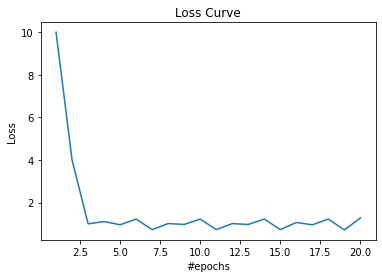


Review Classification Accuracy on Test Data =  80.00  %


In [271]:
epochs = 20

objA = DNN_1Layer(K, 10, 2, 0.015)
objA.fit(epochs)
objA.plotLossCurve(epochs)
objA.predict()

# Hidden Neurons = 15

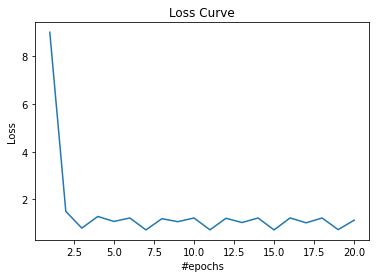


Review Classification Accuracy on Test Data =  90.00  %


In [275]:
objB = DNN_1Layer(K, 10, 2, 0.015)
objB.fit(epochs)
objB.plotLossCurve(epochs)
objB.predict()

The classification accuracy increased from 80% to 90% when no of neurons increased from 10 to 15.